# GoDaddy Microbusiness Density prediction

Main goal of the project is to accurately predict density of microbusiness in Unitd States of America. According to the source of data, which is kaggle competition (https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting).

Microbusiness densiy is one of the indicator which is hard to predict with traditional financial methods. In modern days, when for people is important to have work-life balance and get enough amount for realizing their dreams, opening their own small business is the way to realize those goals. Successes of companies like Microsoft, Alphabet(Google), or Apple, which were started form 'small garage', also encuraging ambitious people to start their own way. From that reasons microbusiness density is very important indicator of well-being of the society.

In this project I'll use train set of the competition data. I will focus on predicting microbusiness density after splitting set into train and test sets. For scoring I'll use metrics like coefficient of determination, root mean squared error and mean absolute error.

## 1. Importing usable modules and defining function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, BayesianRidge, PassiveAggressiveRegressor, Ridge, HuberRegressor
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import warnings
from scipy import stats
from pygam import LinearGAM

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def predictions(model, X_tr, y_tr, X_tst):
    """ Functions which return predictions of the chosen model.
    
    
    Parameters
    -------------
    model:
        Model used for predictions.
    X_tr: 
        Training set.
    y_tr:
        Target feature, used for training of the model
    X_tst:
        Test set.
        
    Returns:
    -------------
    nummpy array
        Function is returning predictions for chosen model.
        
    """
    
    
    model.fit(X_tr, y_tr)
    
    preds = model.predict(X_tst)
    
    return preds

In [4]:
def plot_changes(data, contained_text, label):
    """ Function which is returning two kinds of plots in one viev - bar plot and line plot,
    with changes of mean value of interested feature in time.
    
    Parameters
    -------------
    data: pd.DataFrame
        Include Data Frame from which function is taking data for ploting.
    contained_text: str
        Which fragment of text should include interested columns for plotting.
    label: str
        Title for the plot.
        
    Returns
    -------------
    plt.bar + plt_plot
    
    """
    
    plotted_mean = data[data.columns[data.columns.str.contains(contained_text)]].mean()
    plt.figure(figsize=(12, 6))
    plt.title(label)
    plt.bar(plotted_mean.index, plotted_mean) #bar plot which isshowing means
    plt.plot(plotted_mean.index, plotted_mean, c='r') # line plot which is doing the same
    plt.grid()
    plt.show()

In [5]:
def plot_hists(data, contained_text, title):
    """ Function which is returning histograms, which are showing distribution of features for 
    each year.
    
    Parameters
    -------------
    data: pd.DataFrame
        Include Data Frame from which function is taking data for ploting.
    contained_text: str
        Which fragment of text should include interested columns for plotting.
    title: str
        Title for the plot.
        
    Returns
    -------------
    plt.subplots 
    
    Function returns histograms for every single year.
    
    """
    fig, ax = plt.subplots(2, 3, figsize=(20,8))
    fig.suptitle(f'{title}')
    sns.histplot(data=data, x=f'{contained_text}_2017', ax=ax[0,0], kde=True)
    ax[0,0].grid()
    sns.histplot(data=data, x=f'{contained_text}_2018', ax=ax[0,1], kde=True)
    ax[0,1].grid()
    sns.histplot(data=data, x=f'{contained_text}_2019', ax=ax[0,2], kde=True)
    ax[0,2].grid()
    sns.histplot(data=data, x=f'{contained_text}_2020', ax=ax[1,0], kde=True)
    ax[1,0].grid()
    sns.histplot(data=data, x=f'{contained_text}_2021', ax=ax[1,1], kde=True)
    ax[1,1].grid()
    ax[1,2].axis('off')
    plt.show()

In [6]:
def wilcoxon_test(data_frame, column, target):
    """ Function which is dividing data from given column for two sets - those below median
    and above median in given feature. After that operation function is calculating mean for
    those two sets for given target variables. Next it is using Wilcoxon non-parametrical test
    to check are those two sets statistically different, by looking at target variable. 
    
    Parameters
    -------------
    data: pd.DataFrame
        Include Data Frame from which function is taking data for calculations.
    column: str
        Which column function will use to divide. 
    taget: str
        Target column.
        
    Returns
    -------------
    float, float, float
    
    Function returns mean of target variables from set with values below median for given column,
    next is mean of target variables from set with values above median for given column,
    and at last p-value calculated by Wilcoxon test.
    
    """
    np.random.seed(123) #seting seed to have the same results for each time
   
    higher = data_frame[data_frame[column] > data_frame[column].median()][target] #target variables above median for given column
    
    lower = data_frame[data_frame[column] <= data_frame[column].median()][target] #target variables below median for given column
    
    lower_mean = lower.mean()
    
    higher_mean = higher.mean()
    
    if len(lower) < len(higher):
        
        higher = higher[np.random.choice(higher.index, len(lower), replace=False)] #wilcoxon test need sets in the same lenght, so function randomly is delating few observations
        
        p_value = stats.wilcoxon(higher, lower)[1]
        
    elif len(lower) > len(higher):
        
        lower = lower[np.random.choice(lower.index, len(higher), replace=False)]
        
        p_value = stats.wilcoxon(higher, lower)[1]
    
    else:
        
        p_value = stats.wilcoxon(higher, lower)[1]
        
    return lower_mean, higher_mean, p_value

In [7]:
def voting_function(models, X_tr, y_tr, X_tst):
    """ Function which is returning mean from predictions of given models.
    
    Parameters
    -------------
    models: list
        Models which function is using for predictions
    X_tr:
        Training set.
    y_tr:
        Targer variables used for training.
    X_tst:
        Test set.
        
    Returns
    -------------
    numpy array
    
    Function returns mean of predictions for every single observations, calculated by given models.
    
    """
    
    predictions = [] # empty list to collect predictions for each model
    
    for model in models:
        
        model.fit(X_tr, y_tr)
        
        preds_single = model.predict(X_tst)
        
        predictions.append(preds_single)
        
    
    preds = np.mean(predictions, axis=0) # mean of the prediction
    
    
    return preds

## 2. Data exploration

In [8]:
df = pd.read_csv('train.csv', parse_dates=['first_day_of_month']) 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [10]:
df.shape

(122265, 7)

In [11]:
df.isna().sum()

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64

In [12]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


As it can be seen in the first rows of data set 'train.csv' contains rows:

- row_id - ID of the observation
- cfips - unique identification number of county
- county - name of county
- state - name of state
- first_day_of_month - the day first of the month, from where observation is
- microbusines_density - goal of my predictions
- active - number of active micro-companies

In [13]:
df.describe()

,cfips,microbusiness_density,active
count,122265.000000,122265.000000,1.222650e+05
mean,30376.037640,3.817671,6.442858e+03
std,15143.508721,4.991087,3.304001e+04
min,1001.000000,0.000000,0.000000e+00
25%,18177.000000,1.639344,1.450000e+02
50%,29173.000000,2.586543,4.880000e+02
75%,45077.000000,4.519231,2.124000e+03
max,56045.000000,284.340030,1.167744e+06


Following to a description of data we can see that there is large difference between median and mean of data. Standard deviation shows that there can be large difference between observations. Let's check it on the visualisations.

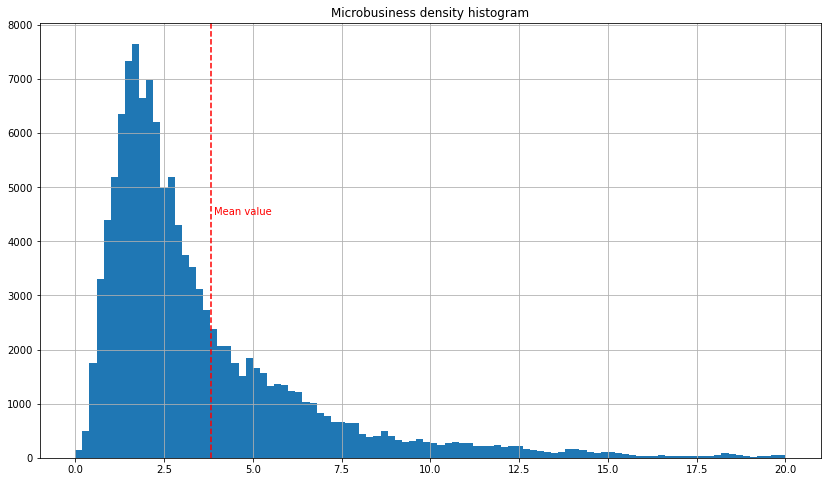

In [14]:
plt.figure(figsize=(14,8))
plt.title('Microbusiness density histogram')
plt.hist(df['microbusiness_density'], bins=100, range=[0, 20]) #column has many outliers, I want to show histogram where density is the highest
plt.axvline(x=df['microbusiness_density'].mean(), c='r', linestyle='--') #to compare density with mean value
plt.text(x=df['microbusiness_density'].mean() + 0.1, y=4500, s='Mean value', c='r')
plt.grid()
plt.show()

As it can be seen most of the data is densed in low values, less than mean.

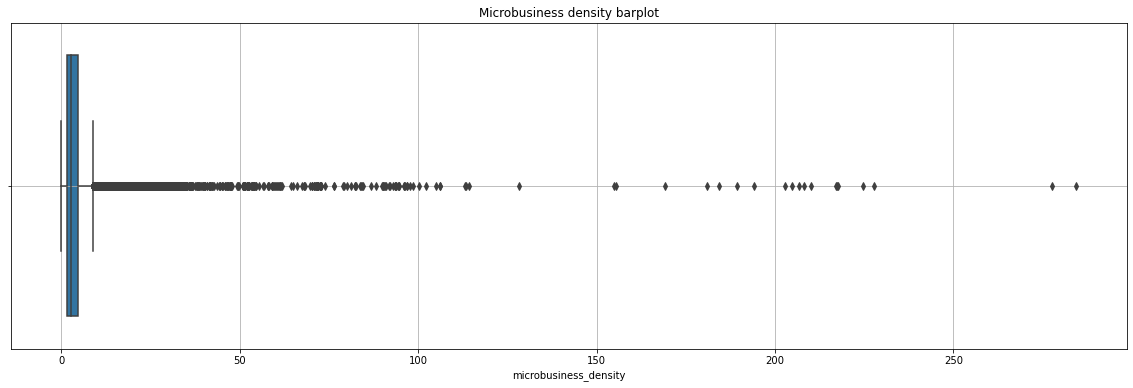

In [15]:
plt.figure(figsize=(20, 6))
plt.title('Microbusiness density barplot')
sns.boxplot(x='microbusiness_density', data=df)
plt.grid()
plt.show()

In boxplot we can see that there are many of outliers, which are much higher than typical values. Are there as much diffrences between counties ? Is it just mistake on collecting data ? Let's look for the highest values.

In [16]:
df[df['microbusiness_density'] > 150]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
68658,32510_2021-02-01,32510,Carson City,Nevada,2021-02-01,154.77109,67409
68659,32510_2021-03-01,32510,Carson City,Nevada,2021-03-01,155.50581,67729
68660,32510_2021-04-01,32510,Carson City,Nevada,2021-04-01,169.16472,73678
68661,32510_2021-05-01,32510,Carson City,Nevada,2021-05-01,181.05341,78856
68662,32510_2021-06-01,32510,Carson City,Nevada,2021-06-01,184.43082,80327
68663,32510_2021-07-01,32510,Carson City,Nevada,2021-07-01,189.30293,82449
68664,32510_2021-08-01,32510,Carson City,Nevada,2021-08-01,194.23015,84595
68665,32510_2021-09-01,32510,Carson City,Nevada,2021-09-01,202.78964,88323
68666,32510_2021-10-01,32510,Carson City,Nevada,2021-10-01,204.76649,89184
68667,32510_2021-11-01,32510,Carson City,Nevada,2021-11-01,206.80765,90073


In [17]:
df[df['cfips'] == 56033]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
121992,56033_2019-08-01,56033,Sheridan County,Wyoming,2019-08-01,30.183279,7065
121993,56033_2019-09-01,56033,Sheridan County,Wyoming,2019-09-01,31.712736,7423
121994,56033_2019-10-01,56033,Sheridan County,Wyoming,2019-10-01,31.990431,7488
121995,56033_2019-11-01,56033,Sheridan County,Wyoming,2019-11-01,32.776520,7672
121996,56033_2019-12-01,56033,Sheridan County,Wyoming,2019-12-01,32.806427,7679
121997,56033_2020-01-01,56033,Sheridan County,Wyoming,2020-01-01,32.847649,7710
121998,56033_2020-02-01,56033,Sheridan County,Wyoming,2020-02-01,32.246933,7569
121999,56033_2020-03-01,56033,Sheridan County,Wyoming,2020-03-01,32.856171,7712
122000,56033_2020-04-01,56033,Sheridan County,Wyoming,2020-04-01,34.142807,8014
122001,56033_2020-05-01,56033,Sheridan County,Wyoming,2020-05-01,40.916836,9604


Definetely it is not a mistake. On data we can see some 'pearls' where microbusiness density is much more higher, or it was increasing really quick. Here appears next important question: is density increasing in general or not ? Let's check. 

In [18]:
mean_density = pd.DataFrame(df.groupby('first_day_of_month')['microbusiness_density'].mean())
mean_density = mean_density.assign(period=np.arange(0, mean_density.shape[0]))

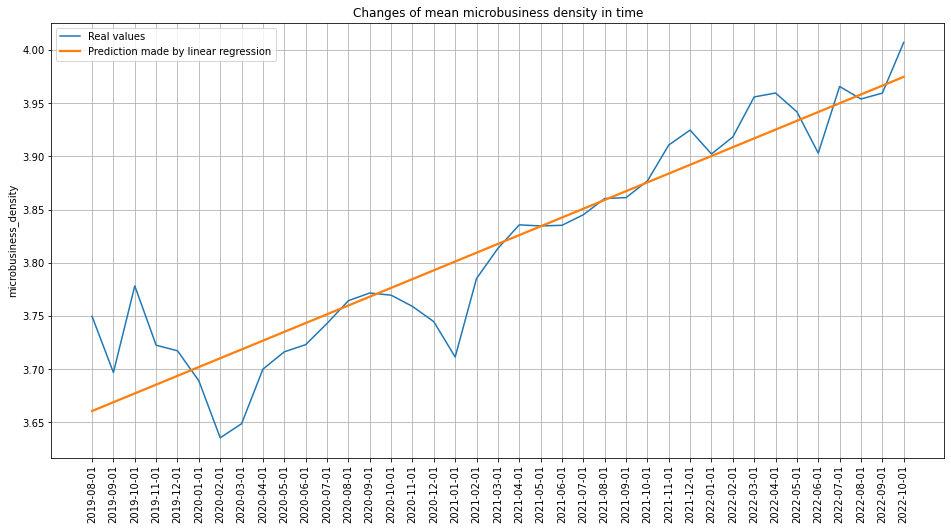

In [19]:
mean_density_labels = [str(i.date()) for i in mean_density.index]
plt.figure(figsize=(16,8))
plt.title('Changes of mean microbusiness density in time')
plt.plot(mean_density['period'], mean_density['microbusiness_density'], label='Real values')
sns.regplot(x='period', y='microbusiness_density', data=mean_density, ci=None, label='Prediction made by linear regression', scatter=False)
plt.xticks(mean_density['period'], mean_density_labels, rotation=90)
plt.legend()
plt.xlabel('')
plt.grid()
plt.show()

Plot shows that in general microbusiness density is increasing. What about diffrences between states ? 

In [20]:
density_by_state = df.groupby('state')['microbusiness_density'].mean().sort_values(ascending=False)

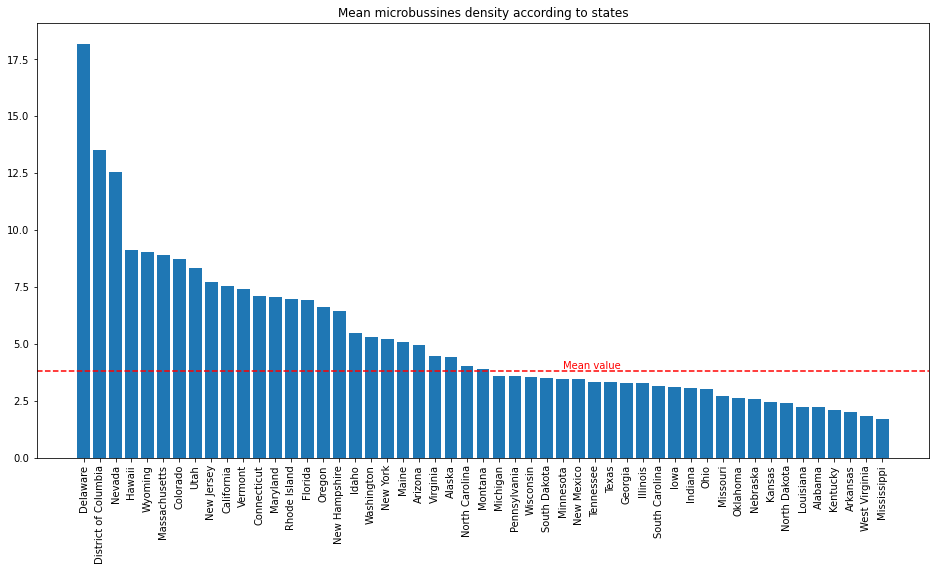

In [21]:
plt.figure(figsize=(16, 8))
plt.title('Mean microbussines density according to states')
plt.bar(density_by_state.index, density_by_state)
plt.axhline(y=df['microbusiness_density'].mean(), c='r', linestyle='--')
plt.text(y=df['microbusiness_density'].mean() + 0.1, x=30, s='Mean value', c='r')
plt.xticks(rotation=90)
plt.show()

As we can see in some states being small business owner is more popular than in other ones. 

Second dataset which I will use is a 'census_starter.csv' which is description of some interesting data of each county year by year from 2017 to 2021. There is:

- pct_collage_[year] - The percent of the population in the county over age 25 with a 4-year college degree
- pct_bb_[year] - The percentage of households in the county with access to broadband of any type
- pct_foreign_born_[year] - The percent of the population in the county born outside of the United States
- pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries
- median_hh_inc_[year] - The median household income in the county

Short look to the data you can see below:

In [22]:
cs = pd.read_csv('census_starter.csv')

In [23]:
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   cfips                  3142 non-null   int64  
 6   pct_college_2017       3142 non-null   float64
 7   pct_college_2018       3142 non-null   float64
 8   pct_college_2019       3142 non-null   float64
 9   pct_college_2020       3141 non-null   float64
 10  pct_college_2021       3141 non-null   float64
 11  pct_foreign_born_2017  3142 non-null   float64
 12  pct_foreign_born_2018  3142 non-null   float64
 13  pct_foreign_born_2019  3142 non-null   float64
 14  pct_foreign_born_2020  3141 non-null   float64
 15  pct_

In [24]:
cs.shape

(3142, 26)

After looking deeper into the data we can see, that in whole dataset there are numerical values. Another connclusion is that, we there are some missing values. Let's take a look:

In [25]:
cs.isna().sum()

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              1
pct_bb_2021              1
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         1
pct_college_2021         1
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    1
pct_foreign_born_2021    1
pct_it_workers_2017      0
pct_it_workers_2018      1
pct_it_workers_2019      0
pct_it_workers_2020      1
pct_it_workers_2021      1
median_hh_inc_2017       0
median_hh_inc_2018       1
median_hh_inc_2019       0
median_hh_inc_2020       2
median_hh_inc_2021       2
dtype: int64

Missing values do not take large part of data. Probably they will not have large influence into modeling.

In [26]:
cs.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [27]:
cs.describe().T

,count,mean,std,min,25%,50%,75%,max
pct_bb_2017,3142.0,69.920401,9.702052,24.5,64.200,70.70,76.40,94.6
pct_bb_2018,3142.0,72.690866,9.255863,25.7,67.425,73.60,78.80,95.5
pct_bb_2019,3142.0,75.398600,8.846665,34.8,70.500,76.45,81.40,96.0
pct_bb_2020,3141.0,78.543298,8.250864,33.3,74.100,79.60,84.10,97.1
pct_bb_2021,3141.0,80.539096,7.889931,37.0,76.400,81.70,85.90,97.6
cfips,3142.0,30383.649268,15162.508374,1001.0,18177.500,29176.00,45080.50,56045.0
pct_college_2017,3142.0,13.813399,5.586649,2.4,9.700,12.80,16.80,43.7
pct_college_2018,3142.0,14.005379,5.630199,0.0,9.900,13.00,17.10,48.0
pct_college_2019,3142.0,14.240452,5.689780,0.0,10.100,13.25,17.30,45.4
pct_college_2020,3141.0,14.631328,5.776940,0.0,10.500,13.60,17.90,43.0


Description shows us some patterns or trends during the time in some features. Bellow I will check those paterns with every feature according to mean.

#### 1. The percentage of households in the county with access to broadband of any type. 

In [28]:
pct_bb = cs[cs.columns[cs.columns.str.contains('pct_bb')]] #using str.contains to find interested columns

In [29]:
pct_bb['cfips'] = cs['cfips']

In [30]:
pct_bb.describe()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips
count,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000,3142.000000
mean,69.920401,72.690866,75.398600,78.543298,80.539096,30383.649268
std,9.702052,9.255863,8.846665,8.250864,7.889931,15162.508374
min,24.500000,25.700000,34.800000,33.300000,37.000000,1001.000000
25%,64.200000,67.425000,70.500000,74.100000,76.400000,18177.500000
50%,70.700000,73.600000,76.450000,79.600000,81.700000,29176.000000
75%,76.400000,78.800000,81.400000,84.100000,85.900000,45080.500000
max,94.600000,95.500000,96.000000,97.100000,97.600000,56045.000000


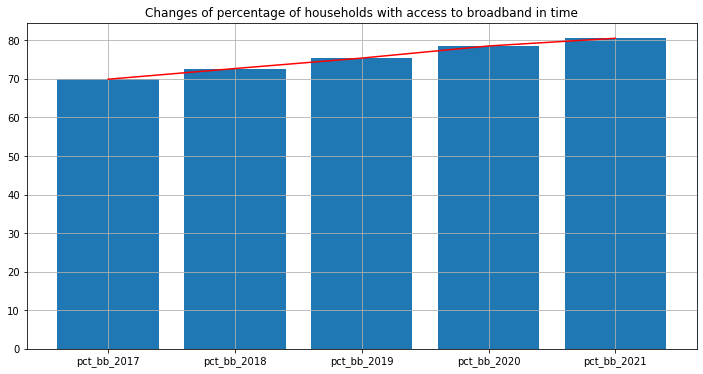

In [31]:
plot_changes(pct_bb, 'pct_bb', 'Changes of percentage of households with access to broadband in time')

As we can see number of broadbands is increasing year by year.

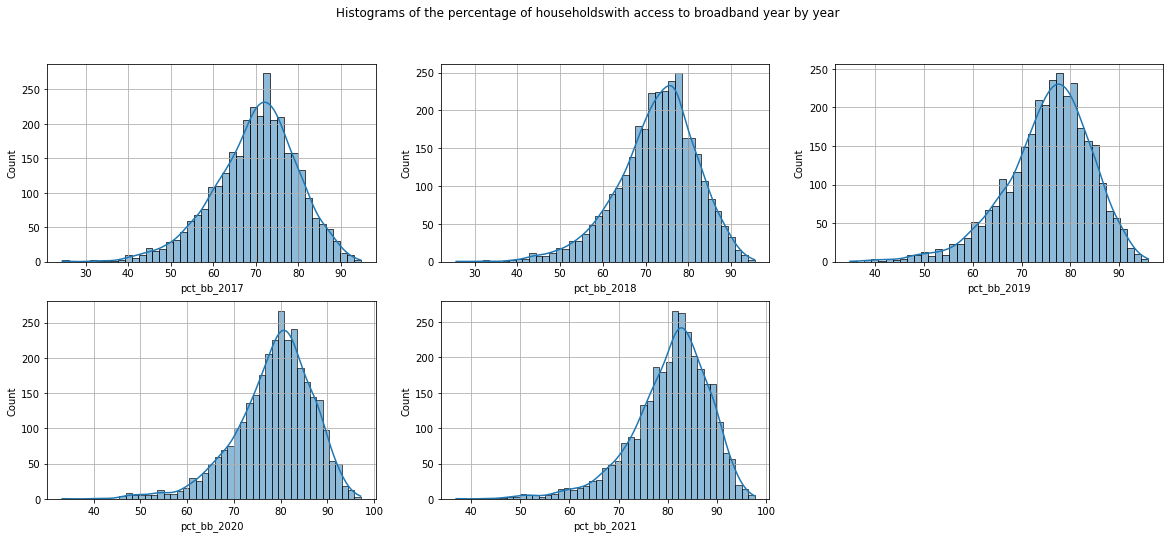

In [32]:
title = 'Histograms of the percentage of householdswith access to broadband year by year'
plot_hists(pct_bb, 'pct_bb', title)

#### 2. The percent of the population in the county over age 25 with a 4-year college degree.

In [33]:
pct_college = cs[cs.columns[cs.columns.str.contains('pct_college')]]

In [34]:
pct_college['cfips'] = cs['cfips']

In [35]:
pct_college.describe()

,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,cfips
count,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000,3142.000000
mean,13.813399,14.005379,14.240452,14.631328,14.851226,30383.649268
std,5.586649,5.630199,5.689780,5.776940,5.832285,15162.508374
min,2.400000,0.000000,0.000000,0.000000,0.000000,1001.000000
25%,9.700000,9.900000,10.100000,10.500000,10.600000,18177.500000
50%,12.800000,13.000000,13.250000,13.600000,13.800000,29176.000000
75%,16.800000,17.100000,17.300000,17.900000,18.000000,45080.500000
max,43.700000,48.000000,45.400000,43.000000,43.700000,56045.000000


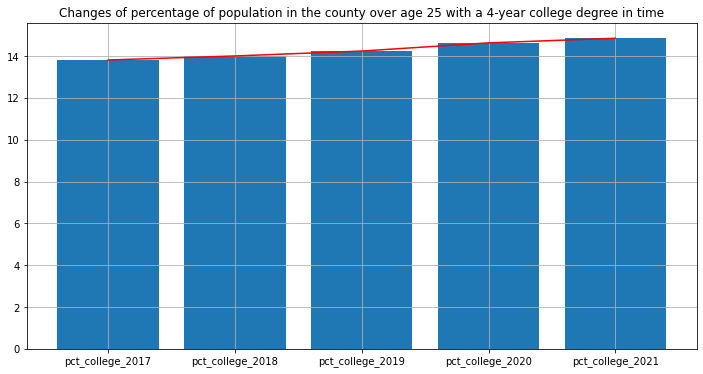

In [36]:
plot_changes(pct_college, 'pct_college', 'Changes of percentage of population in the county over age 25 with a 4-year college degree in time')

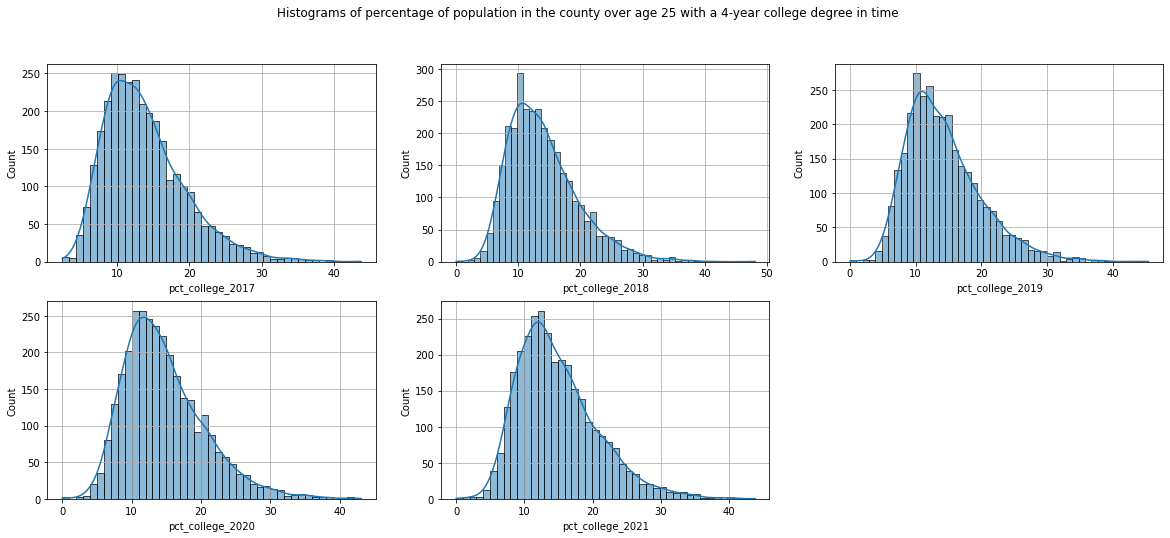

In [37]:
title = 'Histograms of percentage of population in the county over age 25 with a 4-year college degree in time'
plot_hists(pct_college, 'pct_college', title)

Second field of data has the same trend, as it can be seen. It is increasing year by year.

#### 3. The percent of the population in the county born outside of the United States.

In [38]:
pct_foreign_born = cs[cs.columns[cs.columns.str.contains('pct_foreign_born')]]

In [39]:
pct_foreign_born['cfips'] = cs['cfips']

In [40]:
pct_foreign_born.describe()

,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,cfips
count,3142.000000,3142.000000,3142.000000,3141.000000,3141.000000,3142.000000
mean,4.702451,4.724507,4.769096,4.748520,4.743680,30383.649268
std,5.696355,5.705591,5.734774,5.684018,5.724552,15162.508374
min,0.000000,0.000000,0.000000,0.000000,0.000000,1001.000000
25%,1.400000,1.400000,1.400000,1.400000,1.400000,18177.500000
50%,2.700000,2.700000,2.700000,2.800000,2.700000,29176.000000
75%,5.700000,5.700000,5.700000,5.700000,5.700000,45080.500000
max,52.900000,53.300000,53.700000,54.000000,54.000000,56045.000000


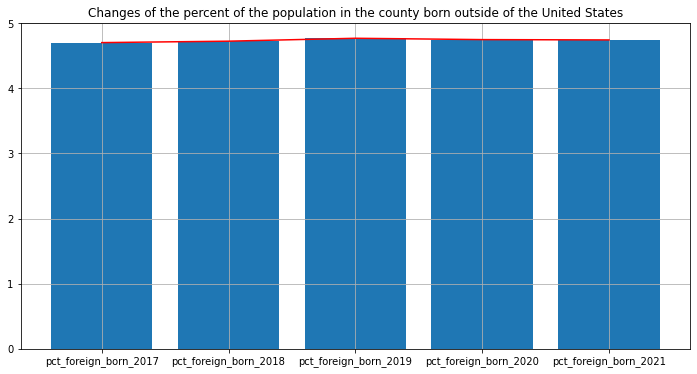

In [41]:
plot_changes(pct_foreign_born, 'pct_foreign_born', 'Changes of the percent of the population in the county born outside of the United States')

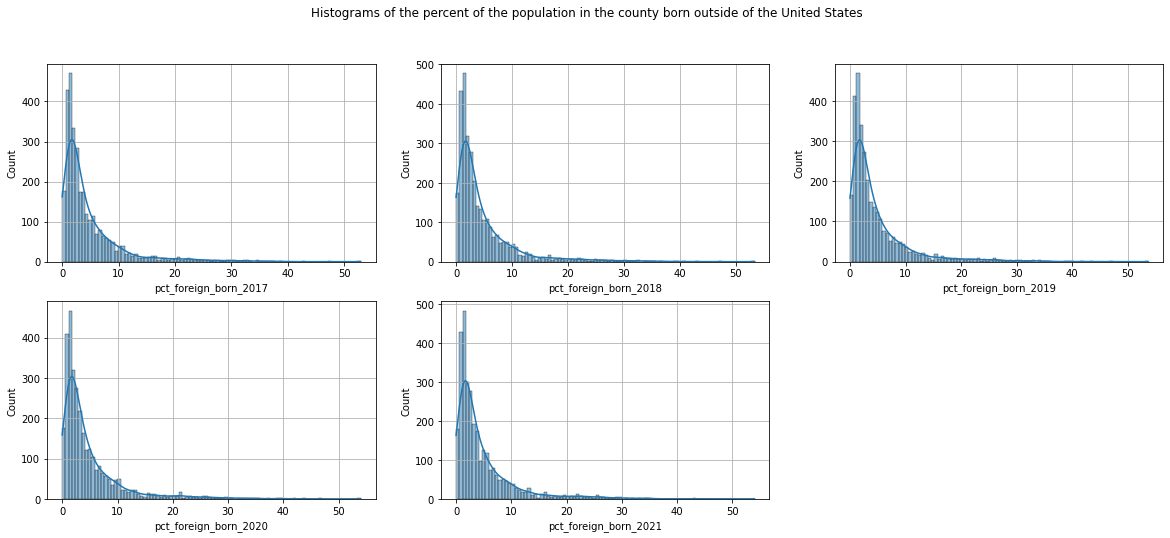

In [42]:
title = 'Histograms of the percent of the population in the county born outside of the United States'
plot_hists(pct_foreign_born, 'pct_foreign_born', title)

Percentage of foreign born during checked years stays in the same level. 

#### 4. The percent of the workforce in the county employed in information related industries.

In [43]:
pct_it_workers = cs[cs.columns[cs.columns.str.contains('pct_it_workers')]]

In [44]:
pct_it_workers['cfips'] = cs['cfips']

In [45]:
pct_it_workers.describe()

,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,cfips
count,3142.000000,3141.000000,3142.000000,3141.000000,3141.000000,3142.000000
mean,1.427148,1.382171,1.338956,1.309265,1.272684,30383.649268
std,0.986985,0.942777,0.940891,0.990342,0.968579,15162.508374
min,0.000000,0.000000,0.000000,0.000000,0.000000,1001.000000
25%,0.800000,0.800000,0.700000,0.700000,0.600000,18177.500000
50%,1.300000,1.300000,1.200000,1.200000,1.100000,29176.000000
75%,1.900000,1.800000,1.800000,1.800000,1.700000,45080.500000
max,17.400000,11.700000,10.500000,15.200000,15.200000,56045.000000


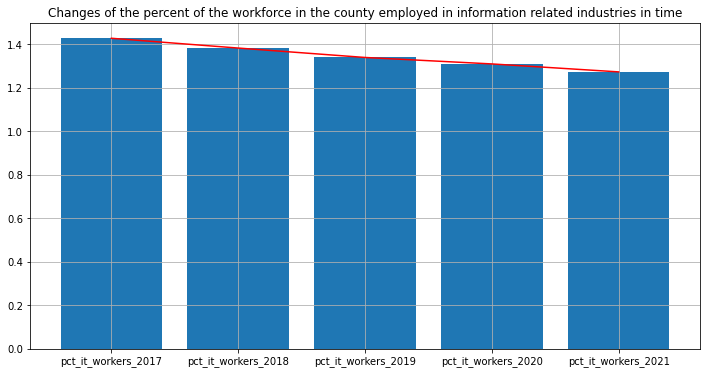

In [46]:
plot_changes(pct_it_workers, 'pct_it_workers', 'Changes of the percent of the workforce in the county employed in information related industries in time')

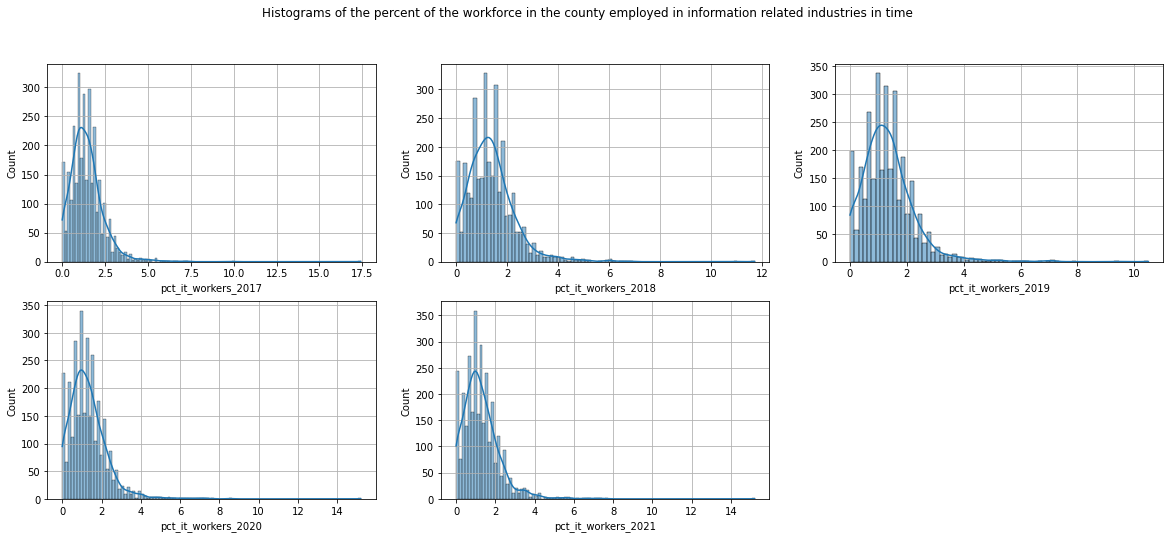

In [47]:
title = 'Histograms of the percent of the workforce in the county employed in information related industries in time'
plot_hists(pct_it_workers, 'pct_it_workers', title)

Next trend check is very interesting. Generally year by year there is lower percentage of people who are employed in information related industries. Diffrence is very low, but still there is a trend to decrease. 

#### 5. The median household income in the county.

In [48]:
median_hh_inc = cs[cs.columns[cs.columns.str.contains('median_hh_inc')]]

In [49]:
median_hh_inc['cfips'] = cs['cfips']

In [50]:
median_hh_inc.describe()

,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,cfips
count,3142.000000,3141.000000,3142.000000,3140.000000,3140.000000,3142.000000
mean,49754.163908,51583.175422,53475.909612,55012.443312,58223.339490,30383.649268
std,13154.424871,13703.502202,14192.529173,14649.568591,15541.038914,15162.508374
min,19264.000000,20188.000000,21504.000000,22292.000000,17109.000000,1001.000000
25%,41123.000000,42480.000000,44155.000000,45653.000000,48179.500000,18177.500000
50%,48065.500000,49888.000000,51757.500000,52842.000000,55907.000000,29176.000000
75%,55763.500000,57611.000000,59867.250000,61500.750000,64930.000000,45080.500000
max,129588.000000,136268.000000,142299.000000,147111.000000,156821.000000,56045.000000


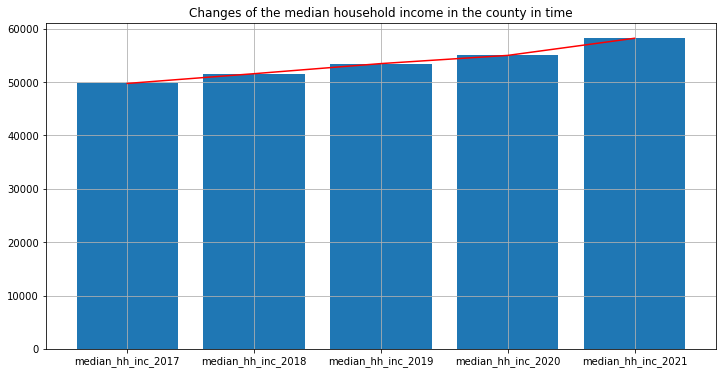

In [51]:
plot_changes(median_hh_inc, 'median_hh_inc', 'Changes of the median household income in the county in time')

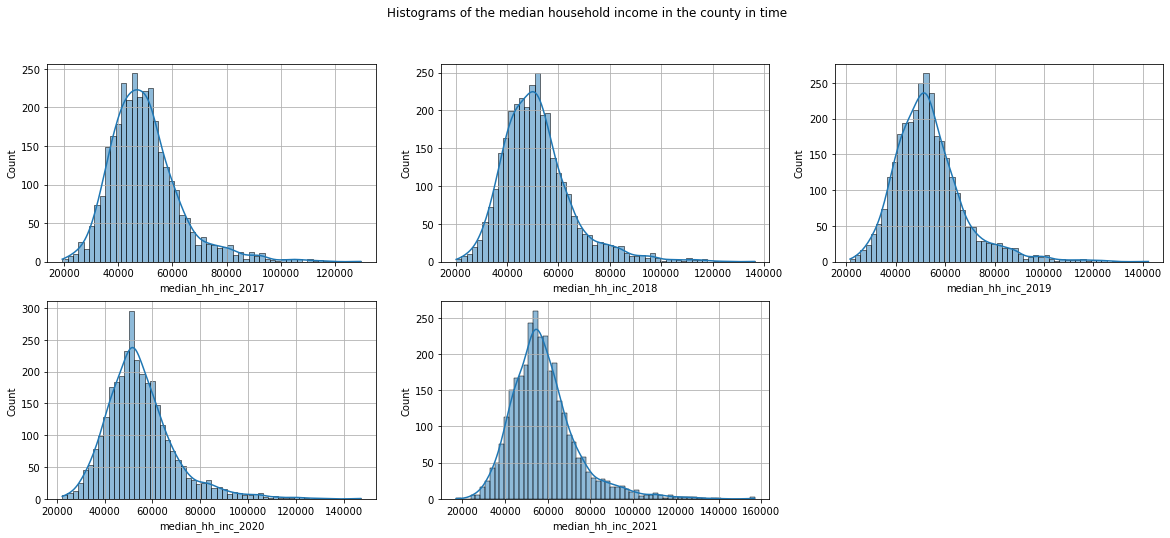

In [52]:
title = 'Histograms of the median household income in the county in time'
plot_hists(median_hh_inc, 'median_hh_inc', title)

Median household income is inreasing, and it is inreasing very quickly. According to increase of microbusiness density it can mean that microbusiness density has influance for income. Or maybe if people have better incomes they are more willing for opening own businesses ?

## 3. Data preparation

Before any modelling or any calculations based staight on data should be preparated. First descibe few conslusions about data form two datasets:

- dataset called 'df' in this notebook is definetely time series data, but specified for every single county
- for time series data we should use 'lags', because previous observations have influance for present observation
- both datsets should be merged, but columns which describe present year or future years should't be used for single observation

Let's start from the lat point:

In [53]:
df_merged = df.merge(cs, on='cfips')

Another inportant operation is to set indexes in right order, first cfips (identification numer of county), next date. Than there will be right order for calculations as a time series.

In [54]:
df_merged = df_merged.set_index(['cfips', 'first_day_of_month'])

In [55]:
df_merged.head()

row_id          county    state  \
cfips first_day_of_month                                             
1001  2019-08-01          1001_2019-08-01  Autauga County  Alabama   
      2019-09-01          1001_2019-09-01  Autauga County  Alabama   
      2019-10-01          1001_2019-10-01  Autauga County  Alabama   
      2019-11-01          1001_2019-11-01  Autauga County  Alabama   
      2019-12-01          1001_2019-12-01  Autauga County  Alabama   

                          microbusiness_density  active  pct_bb_2017  \
cfips first_day_of_month                                               
1001  2019-08-01                       3.007682    1249         76.6   
      2019-09-01                       2.884870    1198         76.6   
      2019-10-01                       3.055843    1269         76.6   
      2019-11-01                       2.993233    1243         76.6   
      2019-12-01                       2.993233    1243         76.6   

                          pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  \
cfips first_day_of_month                                                       
1001  2019-08-01                 78.9         80.6         82.7         85.5   
      2019-09-01                 78.9         80.6         82.7         85.5   
      2019-10-01                 78.9         80.6         82.7         85.5   
      2019-11-01                 78.9         80.6         82.7         85.5   
      2019-12-01                 78.9         80.6         82.7         85.5   

                          ...  pct_it_workers_2017  pct_it_workers_2018  \
cfips first_day_of_month  ...                                             
1001  2019-08-01          ...                  1.3                  1.1   
      2019-09-01          ...                  1.3                  1.1   
      2019-10-01          ...                  1.3                  1.1   
      2019-11-01          ...                  1.3                  1.1   
      2019-12-01          ...                  1.3                  1.1   

                          pct_it_workers_2019  pct_it_workers_2020  \
cfips first_day_of_month                                             
1001  2019-08-01                          0.7                  0.6   
      2019-09-01                          0.7                  0.6   
      2019-10-01                          0.7                  0.6   
      2019-11-01                          0.7                  0.6   
      2019-12-01                          0.7                  0.6   

                          pct_it_workers_2021  median_hh_inc_2017  \
cfips first_day_of_month                                            
1001  2019-08-01                          1.1               55317   
      2019-09-01                          1.1               55317   
      2019-10-01                          1.1               55317   
      2019-11-01                          1.1               55317   
      2019-12-01                          1.1               55317   

                          median_hh_inc_2018  median_hh_inc_2019  \
cfips first_day_of_month                                           
1001  2019-08-01                     58786.0               58731   
      2019-09-01                     58786.0               58731   
      2019-10-01                     58786.0               58731   
      2019-11-01                     58786.0               58731   
      2019-12-01                     58786.0               58731   

                          median_hh_inc_2020  median_hh_inc_2021  
cfips first_day_of_month                                          
1001  2019-08-01                     57982.0             62660.0  
      2019-09-01                     57982.0             62660.0  
      2019-10-01                     57982.0             62660.0  
      2019-11-01                     57982.0             62660.0  
      2019-12-01                     57982.0             62660.0  

[5 rows x 30 columns]

As it was written before, there will be use from columns from 'cs' dataset, just from years before each observations. For this purpose I used just two years back, to not collect large numbers of missing values (first observation was on 2019, first data in 'cs' dataset are from 2017), and 'for' loop.

In [56]:
df_index = df_merged.index.get_level_values(0) # to get cfips

In [57]:
df_index_unique = df_index.drop_duplicates() # to get just unique cfips

In [58]:
df_dates = df_merged.index.get_level_values(1).unique() # the same operation wit dates

In [59]:
pct_bb_1 = []
pct_bb_2 = []

pct_college_1 = []
pct_college_2 = []

pct_foreign_born_1 = []
pct_foreign_born_2 = []

pct_it_workers_1 = []
pct_it_workers_2 = []

median_hh_inc_1 = []
median_hh_inc_2 = []

In [60]:
for indx, date in df_merged.index:
    
    pct_bb_1.append(df_merged.loc[(indx, date)][f'pct_bb_{date.year - 1}']) # appending to list right year - 1 value
    pct_bb_2.append(df_merged.loc[(indx, date)][f'pct_bb_{date.year - 2}'])
        
    pct_college_1.append(df_merged.loc[(indx, date)][f'pct_college_{date.year - 1}'])
    pct_college_2.append(df_merged.loc[(indx, date)][f'pct_college_{date.year - 2}'])
        
    pct_foreign_born_1.append(df_merged.loc[(indx, date)][f'pct_foreign_born_{date.year - 1}'])
    pct_foreign_born_2.append(df_merged.loc[(indx, date)][f'pct_foreign_born_{date.year - 2}'])
        
    pct_it_workers_1.append(df_merged.loc[(indx, date)][f'pct_it_workers_{date.year - 1}'])
    pct_it_workers_2.append(df_merged.loc[(indx, date)][f'pct_it_workers_{date.year - 2}'])
        
    median_hh_inc_1.append(df_merged.loc[(indx, date)][f'median_hh_inc_{date.year - 1}'])
    median_hh_inc_2.append(df_merged.loc[(indx, date)][f'median_hh_inc_{date.year - 2}'])

In [61]:
df_merged.shape

(122265, 30)

In [62]:
df_merged['pct_bb_1'] = pct_bb_1 # crating new columns with year - 1 and year - 1 values
df_merged['pct_bb_2'] = pct_bb_2

df_merged['pct_college_1'] = pct_college_1
df_merged['pct_college_2'] = pct_college_2

df_merged['pct_foreign_born_1'] = pct_foreign_born_1
df_merged['pct_foreign_born_2'] = pct_foreign_born_2

df_merged['pct_it_workers_1'] = pct_it_workers_1
df_merged['pct_it_workers_2'] = pct_it_workers_2

df_merged['median_hh_inc_1'] = median_hh_inc_1
df_merged['median_hh_inc_2'] = median_hh_inc_2

Let's do some simple tests of correctness:

In [63]:
df_merged.shape

(122265, 40)

In [64]:
df_merged.iloc[31232:31233] #choosing the random row

,,row_id,county,state,microbusiness_density,active,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,...,pct_bb_1,pct_bb_2,pct_college_1,pct_college_2,pct_foreign_born_1,pct_foreign_born_2,pct_it_workers_1,pct_it_workers_2,median_hh_inc_1,median_hh_inc_2
cfips,first_day_of_month,,,,,,,,,,,,,,,,,,,,,
19027,2022-04-01,19027_2022-04-01,Carroll County,Iowa,3.681379,568,73.2,76.7,79.3,80.6,82.4,...,82.4,80.6,16.9,18.1,1.9,2.0,0.6,0.8,61157.0,59198.0


In [65]:
df_merged.iloc[31232:31233][['pct_bb_2021', 'pct_bb_1']] #checkin is the column with year - 1 and value from real year - 1 the same

,,pct_bb_2021,pct_bb_1
cfips,first_day_of_month,,
19027,2022-04-01,82.4,82.4


After adding new columns, it is time to delate those, which are not nessesary:

In [66]:
df_deleted = df_merged.drop(df_merged.columns[df_merged.columns.str.contains('2017|2018|2019|2020|2021|2021')], axis=1)

In [67]:
df_deleted.shape

(122265, 15)

Another purpose of data preparations is to add columns which include 'lags' with microbusiness density from provious observations. For this goal I'll also use 'for' loops.

In [68]:
df_first = df_deleted.loc[df_index_unique[0]] # operation with choosing data for first cfips from the list

In [69]:
for i in range(12):
    df_first[f'period_{i+1}'] = df_first['microbusiness_density'].shift(i+1) # adding columns with lags, for first cfips

In [70]:
df_first.iloc[0:10][['microbusiness_density', 'period_1', 'period_2', 'period_3']] # checking the correctness

,microbusiness_density,period_1,period_2,period_3
first_day_of_month,,,,
2019-08-01,3.007682,NaN,NaN,NaN
2019-09-01,2.884870,3.007682,NaN,NaN
2019-10-01,3.055843,2.884870,3.007682,NaN
2019-11-01,2.993233,3.055843,2.884870,3.007682
2019-12-01,2.993233,2.993233,3.055843,2.884870
2020-01-01,2.969090,2.993233,2.993233,3.055843
2020-02-01,2.909326,2.969090,2.993233,2.993233
2020-03-01,2.933231,2.909326,2.969090,2.993233
2020-04-01,3.000167,2.933231,2.909326,2.969090


In [71]:
for indx in range(len(df_index_unique) - 1): # making the same for every single county
    shifter = df_deleted.loc[df_index_unique[indx + 1]]
    for s in range(12):
        shifter[f'period_{s+1}'] = shifter['microbusiness_density'].shift(s+1)
    df_first = pd.concat([df_first, shifter]) # concatenation of results

Let's check some example of result of those operations:

In [72]:
df_first.iloc[10000:10010][['microbusiness_density', 'period_1', 'period_2', 'period_3']] # the same check as above

,microbusiness_density,period_1,period_2,period_3
first_day_of_month,,,,
2020-12-01,8.776042,8.567708,8.619792,8.880208
2021-01-01,8.448276,8.776042,8.567708,8.619792
2021-02-01,9.704433,8.448276,8.776042,8.567708
2021-03-01,9.729064,9.704433,8.448276,8.776042
2021-04-01,9.827586,9.729064,9.704433,8.448276
2021-05-01,9.704433,9.827586,9.729064,9.704433
2021-06-01,9.704433,9.704433,9.827586,9.729064
2021-07-01,9.852217,9.704433,9.704433,9.827586
2021-08-01,9.852217,9.852217,9.704433,9.704433


And let's make right indexes again:

In [73]:
df_new = df_first # changing name of DataFrame

In [74]:
df_new['cfips'] = df_index # bringing back cfips columns

In [75]:
df_new.head()

,row_id,county,state,microbusiness_density,active,pct_bb_1,pct_bb_2,pct_college_1,pct_college_2,pct_foreign_born_1,...,period_4,period_5,period_6,period_7,period_8,period_9,period_10,period_11,period_12,cfips
first_day_of_month,,,,,,,,,,,,,,,,,,,,,
2019-08-01,1001_2019-08-01,Autauga County,Alabama,3.007682,1249,78.9,76.6,15.9,14.5,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1001
2019-09-01,1001_2019-09-01,Autauga County,Alabama,2.884870,1198,78.9,76.6,15.9,14.5,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1001
2019-10-01,1001_2019-10-01,Autauga County,Alabama,3.055843,1269,78.9,76.6,15.9,14.5,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1001
2019-11-01,1001_2019-11-01,Autauga County,Alabama,2.993233,1243,78.9,76.6,15.9,14.5,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1001
2019-12-01,1001_2019-12-01,Autauga County,Alabama,2.993233,1243,78.9,76.6,15.9,14.5,2.0,...,3.007682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1001


In [76]:
df_new['first_day_of_month'] = df_new.index

In [77]:
df_new = df_new.set_index(['cfips', 'first_day_of_month']) # bringing back past indexes

In [78]:
df_new.head()

row_id          county    state  \
cfips first_day_of_month                                             
1001  2019-08-01          1001_2019-08-01  Autauga County  Alabama   
      2019-09-01          1001_2019-09-01  Autauga County  Alabama   
      2019-10-01          1001_2019-10-01  Autauga County  Alabama   
      2019-11-01          1001_2019-11-01  Autauga County  Alabama   
      2019-12-01          1001_2019-12-01  Autauga County  Alabama   

                          microbusiness_density  active  pct_bb_1  pct_bb_2  \
cfips first_day_of_month                                                      
1001  2019-08-01                       3.007682    1249      78.9      76.6   
      2019-09-01                       2.884870    1198      78.9      76.6   
      2019-10-01                       3.055843    1269      78.9      76.6   
      2019-11-01                       2.993233    1243      78.9      76.6   
      2019-12-01                       2.993233    1243      78.9      76.6   

                          pct_college_1  pct_college_2  pct_foreign_born_1  \
cfips first_day_of_month                                                     
1001  2019-08-01                   15.9           14.5                 2.0   
      2019-09-01                   15.9           14.5                 2.0   
      2019-10-01                   15.9           14.5                 2.0   
      2019-11-01                   15.9           14.5                 2.0   
      2019-12-01                   15.9           14.5                 2.0   

                          ...  period_3  period_4  period_5  period_6  \
cfips first_day_of_month  ...                                           
1001  2019-08-01          ...       NaN       NaN       NaN       NaN   
      2019-09-01          ...       NaN       NaN       NaN       NaN   
      2019-10-01          ...       NaN       NaN       NaN       NaN   
      2019-11-01          ...  3.007682       NaN       NaN       NaN   
      2019-12-01          ...  2.884870  3.007682       NaN       NaN   

                          period_7  period_8  period_9  period_10  period_11  \
cfips first_day_of_month                                                       
1001  2019-08-01               NaN       NaN       NaN        NaN        NaN   
      2019-09-01               NaN       NaN       NaN        NaN        NaN   
      2019-10-01               NaN       NaN       NaN        NaN        NaN   
      2019-11-01               NaN       NaN       NaN        NaN        NaN   
      2019-12-01               NaN       NaN       NaN        NaN        NaN   

                          period_12  
cfips first_day_of_month             
1001  2019-08-01                NaN  
      2019-09-01                NaN  
      2019-10-01                NaN  
      2019-11-01                NaN  
      2019-12-01                NaN  

[5 rows x 27 columns]

Another idea is to make some categorical features for months. In some datas season have some influence for the results, maybe on this dataset it also will work.

In [79]:
df_new['month'] = df_first.index.month

In [80]:
months = pd.get_dummies(df_new['month'], prefix='month') # one hot encoding for month columns

In [81]:
df_new = pd.concat([df_new, months], axis=1)

In [82]:
df_new.head()

row_id          county    state  \
cfips first_day_of_month                                             
1001  2019-08-01          1001_2019-08-01  Autauga County  Alabama   
      2019-09-01          1001_2019-09-01  Autauga County  Alabama   
      2019-10-01          1001_2019-10-01  Autauga County  Alabama   
      2019-11-01          1001_2019-11-01  Autauga County  Alabama   
      2019-12-01          1001_2019-12-01  Autauga County  Alabama   

                          microbusiness_density  active  pct_bb_1  pct_bb_2  \
cfips first_day_of_month                                                      
1001  2019-08-01                       3.007682    1249      78.9      76.6   
      2019-09-01                       2.884870    1198      78.9      76.6   
      2019-10-01                       3.055843    1269      78.9      76.6   
      2019-11-01                       2.993233    1243      78.9      76.6   
      2019-12-01                       2.993233    1243      78.9      76.6   

                          pct_college_1  pct_college_2  pct_foreign_born_1  \
cfips first_day_of_month                                                     
1001  2019-08-01                   15.9           14.5                 2.0   
      2019-09-01                   15.9           14.5                 2.0   
      2019-10-01                   15.9           14.5                 2.0   
      2019-11-01                   15.9           14.5                 2.0   
      2019-12-01                   15.9           14.5                 2.0   

                          ...  month_3  month_4  month_5  month_6  month_7  \
cfips first_day_of_month  ...                                                
1001  2019-08-01          ...        0        0        0        0        0   
      2019-09-01          ...        0        0        0        0        0   
      2019-10-01          ...        0        0        0        0        0   
      2019-11-01          ...        0        0        0        0        0   
      2019-12-01          ...        0        0        0        0        0   

                          month_8  month_9  month_10  month_11  month_12  
cfips first_day_of_month                                                  
1001  2019-08-01                1        0         0         0         0  
      2019-09-01                0        1         0         0         0  
      2019-10-01                0        0         1         0         0  
      2019-11-01                0        0         0         1         0  
      2019-12-01                0        0         0         0         1  

[5 rows x 40 columns]

In [83]:
df_new.columns

Index(['row_id', 'county', 'state', 'microbusiness_density', 'active',
       'pct_bb_1', 'pct_bb_2', 'pct_college_1', 'pct_college_2',
       'pct_foreign_born_1', 'pct_foreign_born_2', 'pct_it_workers_1',
       'pct_it_workers_2', 'median_hh_inc_1', 'median_hh_inc_2', 'period_1',
       'period_2', 'period_3', 'period_4', 'period_5', 'period_6', 'period_7',
       'period_8', 'period_9', 'period_10', 'period_11', 'period_12', 'month',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

After those operations let's delate not nessesary columns:

- row_id - ID of the row - is is not important information
- county - name of the county, also not nessesary
- state - that column can be included as categorical data, because as it was seen in plots, there are large differences between states, but also using one hot encoding for this column will produce too many of columns
- month - changed into one hot encodng columns
- active - number of active small business in each county - it is not right to use known number of small businesses to predict microbusiness density, actually we shouldn't know that.

In [84]:
df_new.drop(['row_id', 'county', 'state', 'month', 'active'], axis=1, inplace=True)

At the end of this part I want to look into numbers of missing data:

In [85]:
df_new.isna().sum()

microbusiness_density        0
pct_bb_1                     0
pct_bb_2                     0
pct_college_1                0
pct_college_2                0
pct_foreign_born_1           0
pct_foreign_born_2           0
pct_it_workers_1             5
pct_it_workers_2            12
median_hh_inc_1             27
median_hh_inc_2             22
period_1                  3135
period_2                  6270
period_3                  9405
period_4                 12540
period_5                 15675
period_6                 18810
period_7                 21945
period_8                 25080
period_9                 28215
period_10                31350
period_11                34485
period_12                37620
month_1                      0
month_2                      0
month_3                      0
month_4                      0
month_5                      0
month_6                      0
month_7                      0
month_8                      0
month_9                      0
month_10

As we can see, many od columns which are products of 'lags' include missing values. It can be understood, because our dataset have it's beginning in time. Later I will use some operations to deal with it.

## 4. Statistical analysis

In this chapter I want to check few things:

- look into correlations between columns
- test our target columns for normality (it will be important for another tests)
- test columns which include data from 'cs' dataset have statistically important influence for target column

Let's start!

In [86]:
df_without_months = df_new[df_new.columns[~df_new.columns.str.contains('month')]] # DataFrame without month, to save space

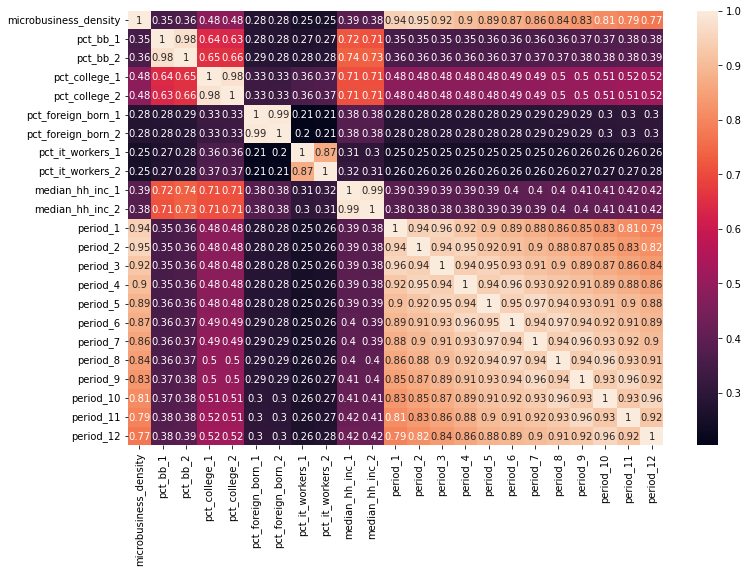

In [87]:
plt.figure(figsize=(12,8))
sns.heatmap(df_without_months.corr(), annot=True)
plt.show()

After looking into heatmap with correlations betwen columns we can make some conclusions:

- columns with periods are highly corelated, when periods are closer to each other, than corelation is higher
- the same situaton is with columns with features taken from 'cs' dataset, they are building 'squares' in the heatmap with high correlations
- columns with periods which are more far from current observations have little higher correlation with those which are closer to features from 'cs' dataset. It can mean that present state has larger influance than past.
- interesing is correlation between columns which include 'pct_bb', 'pct_college', 'median_hh', because correlation between them is quite large, so there is some influence between them
- as it was seen before on other plots, change of percentege of IT workers is large, correlation betwen year - 1 and year - 2 is high, but the lowest from all other 'cs' dataset based features
- from 'cs' dataset based columns largest correlation for target column is between this column and percentge of people who finished higher education(but also not very high). Does it mean that higher educated people are more likely for opening small businesses ?

Another important thing for later investigations is to test our target data for normality:

In [88]:
ks_pvalue = stats.kstest(df_new['microbusiness_density'], 'norm')[1]
print(f'P-value for column "microbusiness_density" using Kolmogorov-Smirnov test is: {ks_pvalue}.')
if ks_pvalue > 0.05:
    print('Column is normally distributed.')
else:
    print('Column is not normally distributed.')

P-value for column "microbusiness_density" using Kolmogorov-Smirnov test is: 0.0.
Column is not normally distributed.


In [89]:
shapiro_pvalue = stats.shapiro(df_new['microbusiness_density'])[1]
print(f'P-value for column "microbusiness_density" using Shapiro-Wilk test is: {ks_pvalue}.')
if shapiro_pvalue > 0.05:
    print('Column is normally distributed.')
else:
    print('Column is not normally distributed.')

P-value for column "microbusiness_density" using Shapiro-Wilk test is: 0.0.
Column is not normally distributed.


As we can see data is not normally distributed. My idea was to check are the columns based on 'cs' dataset statistically important for result of 'microbusiness density'. As it was seen in the correlation heatmap, correlations between those features and target column are not very high. Another method is to use statistical tests. How I will make it:

- I will divide dataset for each interested columns for two parts: with higher value of each feature, and lower
- Because target columns is not normally distributed I will use non-parametrical Wilcoxon test
- Wilcoxon test need to have two datasets in the same lenght, so I will delete some random values, if one of datasets will be larger
- H0 is that larger than median values for each features have also higher microbusiness densities
- H1 is that larger than median values have no influance for higher microbusinees densities

In [90]:
interested_columns = df_new.columns[df_new.columns.str.contains('pct|median')]

In [91]:
interested_columns

Index(['pct_bb_1', 'pct_bb_2', 'pct_college_1', 'pct_college_2',
       'pct_foreign_born_1', 'pct_foreign_born_2', 'pct_it_workers_1',
       'pct_it_workers_2', 'median_hh_inc_1', 'median_hh_inc_2'],
      dtype='object')

In [92]:
for column in interested_columns:
    
    test = wilcoxon_test(df_new, column, 'microbusiness_density')
    
    print(column + ' : ' + 'lower mean: ' + str(test[0]) + ', higher mean: ' + str(test[1]) +', p-value: ' + str(test[2]))

pct_bb_1 : lower mean: 2.335100718831342, higher mean: 5.303663863648718, p-value: 0.0
pct_bb_2 : lower mean: 2.3208694374448786, higher mean: 5.338337002739478, p-value: 0.0
pct_college_1 : lower mean: 2.1579029128170544, higher mean: 5.511920705048584, p-value: 0.0
pct_college_2 : lower mean: 2.1452342200222336, higher mean: 5.5012235557473765, p-value: 0.0
pct_foreign_born_1 : lower mean: 2.481282295412929, higher mean: 5.161050591020695, p-value: 0.0
pct_foreign_born_2 : lower mean: 2.4720503999559913, higher mean: 5.173698264155127, p-value: 0.0
pct_it_workers_1 : lower mean: 2.75768085529532, higher mean: 5.0277204963632425, p-value: 0.0
pct_it_workers_2 : lower mean: 2.767510013070971, higher mean: 4.905278290722496, p-value: 0.0
median_hh_inc_1 : lower mean: 2.4956034196637065, higher mean: 5.140204846260319, p-value: 0.0
median_hh_inc_2 : lower mean: 2.5129937549558887, higher mean: 5.122711108801681, p-value: 0.0


Means of microbusiness densities for higher values are higher, as we can see, but statistically is not important. We are rejecting H0 hypothesis.

## 5. Data split & prepocessing

Next step is to split the data into features and target variable, and to split the data into two sets - for training, and testing. 

In [93]:
X = df_new.drop(['microbusiness_density'], axis=1)
y = df_new['microbusiness_density']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

Another important step in preprocessing is to scale the data, because some of the models need to have features in the same scale. I will use the simplest method - StandardScaler. Normally data should be scaled before imputing missing values, but in this example that order will be not correct. Why ?

- This is time series data, and as it was seen in the correlation heatmap, there is large correlation beetween target variable, and observations from previous periods.
- Most of the missing data are in columns which include periods.
- Because of those reasons imputation with mean or median will not show the truth, and have not good influence for modelling.
- For other imputation methods like KNNImputer or IterativeImputer, which are more 'specific' for every single observation,  we need scaled data.

Let's fisrt scale the data:

In [95]:
standard_scaler = StandardScaler()

In [96]:
X_train = pd.DataFrame(np.concatenate([standard_scaler.fit_transform(X_train[X_train.columns[X_train.columns.str.contains('month') == False]]), \
                          X_train[X_train.columns[X_train.columns.str.contains('month')]]], axis=1), columns=X.columns)

In [97]:
X_test = pd.DataFrame(np.concatenate([standard_scaler.transform(X_test[X_test.columns[X_test.columns.str.contains('month') == False]]), \
                          X_test[X_test.columns[X_test.columns.str.contains('month')]]], axis=1), columns=X.columns)

Then let's test my thoughts with two type of models: linear model - Linear Regression, and tree based model - Decission Tree Regressor.

In [98]:
simple_mean_imputer = SimpleImputer()
simple_median_imputer = SimpleImputer(strategy='median')
knn_imputer = KNNImputer()
it_imputer = IterativeImputer() # Default model with Bayesian Ridge (linear model)
it_imputer_dt = IterativeImputer(estimator=DecisionTreeRegressor()) # To check how will work tree based model

In [99]:
imputers = [simple_mean_imputer, simple_median_imputer, knn_imputer, it_imputer, it_imputer_dt]
dt = DecisionTreeRegressor(random_state=123)

In [100]:
for model in imputers:
    
    X_train_im = np.concatenate([model.fit_transform(X_train[X_train.columns[X_train.columns.str.contains('month') == False]]), \
                          X_train[X_train.columns[X_train.columns.str.contains('month')]]], axis=1)
    
    X_test_im = np.concatenate([model.transform(X_test[X_test.columns[X_test.columns.str.contains('month') == False]]), \
                          X_test[X_test.columns[X_test.columns.str.contains('month')]]], axis=1)
    
    dt.fit(X_train_im, y_train)
    
    preds = dt.predict(X_test_im)
    
    score = r2_score(y_test, preds)
    
    print(str(model) + ':   ' + str(score))

SimpleImputer():   0.9664217744099226
SimpleImputer(strategy='median'):   0.9535208284799405
KNNImputer():   0.9880082292842418
IterativeImputer():   0.9756810736618055
IterativeImputer(estimator=DecisionTreeRegressor()):   0.9739030665180471


In [101]:
lr = LinearRegression()

In [102]:
for model in imputers:
    
    X_train_im = np.concatenate([model.fit_transform(X_train[X_train.columns[X_train.columns.str.contains('month') == False]]), \
                          X_train[X_train.columns[X_train.columns.str.contains('month')]]], axis=1)
    
    X_test_im = np.concatenate([model.transform(X_test[X_test.columns[X_test.columns.str.contains('month') == False]]), \
                          X_test[X_test.columns[X_test.columns.str.contains('month')]]], axis=1)
    
    lr.fit(X_train_im, y_train)
    
    preds = dt.predict(X_test_im)
    
    score = r2_score(y_test, preds)
    
    print(str(model) + ':   ' + str(score))

SimpleImputer():   0.960078521720634
SimpleImputer(strategy='median'):   0.9554502817486611
KNNImputer():   0.9763575244168857
IterativeImputer():   0.9675309636241038
IterativeImputer(estimator=DecisionTreeRegressor()):   0.9732946037140571


As we can see, in both models IterativeImputer and KNN Imputer give better results, as I was thinking. But best results are given by KNN Imputer. I will use that kind of imputation for purposeof this project. 

In [103]:
X_train = pd.DataFrame(np.concatenate([knn_imputer.fit_transform(X_train[X_train.columns[X_train.columns.str.contains('month') == False]]), \
                          X_train[X_train.columns[X_train.columns.str.contains('month')]]], axis=1), columns=X.columns)

In [104]:
X_test = pd.DataFrame(np.concatenate([knn_imputer.transform(X_test[X_test.columns[X_test.columns.str.contains('month') == False]]), \
                          X_test[X_test.columns[X_test.columns.str.contains('month')]]], axis=1), columns=X.columns)

## 6. Model testing

In previous chapter there were tested 2 models, in this chapter I'll test 14 other models, in default parameters, setting just the same random_state parameter if it is needed, to not change results, after new opening of notebook. Those models are:

- Random Forest Regressor
- XGB Regressor
- Ridge 
- Passive Aggresive Regressor
- Bagging Regressor
- Cat Boost regressor
- MLP Regressor
- KNeighbors Regressor
- Beyesian Ridge
- Ada Boost Regressor
- Huber Regressor
- LinearGAM - because this model has different api, I'll make 'manual grid search' in this chapter, so mothod used will be different than in other models


In the end of the chapter I'll make a table with ranking of models, ordered by their lowest RMSE.

In [105]:
models = {}

In [106]:
rf = RandomForestRegressor(random_state=123)
xgb = XGBRegressor(random_state=123)
ridge = Ridge(random_state=123)
par = PassiveAggressiveRegressor(random_state=123)
bag = BaggingRegressor(random_state=123)
lgbm = LGBMRegressor(random_state=123)
cat = CatBoostRegressor(random_state=123, verbose=False)
mlp = MLPRegressor(random_state=123)
svm = SVR()
knn = KNeighborsRegressor()
br = BayesianRidge()
ada = AdaBoostRegressor(random_state=123)
huber = HuberRegressor()

#### 1. Random Forest Regressor

In [107]:
rf_predictions = predictions(rf, X_train, y_train, X_test)
rf_r2 = r2_score(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f'R2 for Random Forest Regressor is: {rf_r2}')
print(f'RMSE for Random Forest Regressor is: {rf_rmse}')
models['Random Forest Regressor'] = [rf_r2, rf_rmse]

R2 for Random Forest Regressor is: 0.9840283221564109
RMSE for Random Forest Regressor is: 0.6245700420335866


#### 2. XGB Regressor

In [108]:
xgb_predictions = predictions(xgb, X_train, y_train, X_test)
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f'R2 for XGB Regressor is: {xgb_r2}')
print(f'RMSE for XGB Regressor is: {xgb_rmse}')
models['XGB Regressor'] = [xgb_r2, xgb_rmse]

R2 for XGB Regressor is: 0.9773188264767713
RMSE for XGB Regressor is: 0.7442839244187636


#### 3. Ridge

In [109]:
ridge_predictions = predictions(ridge, X_train, y_train, X_test)
ridge_r2 = r2_score(y_test, ridge_predictions)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
print(f'R2 for Ridge is: {ridge_r2}')
print(f'RMSE for Ridge is: {ridge_rmse}')
models['Ridge'] = [ridge_r2, ridge_rmse]

R2 for Ridge is: 0.9658972994825515
RMSE for Ridge is: 0.9126416062978411


#### 4. Passive Aggresive Regressor

In [110]:
par_predictions = predictions(par, X_train, y_train, X_test)
par_r2 = r2_score(y_test, par_predictions)
par_rmse = np.sqrt(mean_squared_error(y_test, par_predictions))
print(f'R2 for Passive Aggressive Regressor is: {par_r2}')
print(f'RMSE for Passive Aggresive Regressor is: {par_rmse}')
models['Passive Aggresive Regressor'] = [par_r2, par_rmse]

R2 for Passive Aggressive Regressor is: 0.9778228080876654
RMSE for Passive Aggresive Regressor is: 0.7359683797432226


#### 5. Bagging Regressor

In [111]:
bag_predictions = predictions(bag, X_train, y_train, X_test)
bag_r2 = r2_score(y_test, bag_predictions)
bag_rmse = np.sqrt(mean_squared_error(y_test, bag_predictions))
print(f'R2 for Bagging Regressor is: {bag_r2}')
print(f'RMSE for Bagging Regressor is: {bag_rmse}')
models['Bagging Regressor'] = [bag_r2, bag_rmse]

R2 for Bagging Regressor is: 0.9772994564639563
RMSE for Bagging Regressor is: 0.7446016705975974


#### 6. LGBM Regressor

In [112]:
lgbm_predictions = predictions(lgbm, X_train, y_train, X_test)
lgbm_r2 = r2_score(y_test, lgbm_predictions)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_predictions))
print(f'R2 for LGBM Regressor is: {lgbm_r2}')
print(f'RMSE for LGBM Regressor is: {lgbm_rmse}')
models['LGBM Regressor'] = [lgbm_r2, lgbm_rmse]

R2 for LGBM Regressor is: 0.9634050249905528
RMSE for LGBM Regressor is: 0.9454021938159246


#### 7. Cat Boost Regressor

In [113]:
cat_predictions = predictions(cat, X_train, y_train, X_test)
cat_r2 = r2_score(y_test, cat_predictions)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_predictions))
print(f'R2 for Cat Boost Regressor is: {cat_r2}')
print(f'RMSE for Cat Boost Regressor is: {cat_rmse}')
models['Cat Boost Regressor'] = [cat_r2, cat_rmse]

R2 for Cat Boost Regressor is: 0.9727108987377895
RMSE for Cat Boost Regressor is: 0.8163952979710134


#### 8. MLP Regressor (Neural networks)

In [114]:
mlp_predictions = predictions(mlp, X_train, y_train, X_test)
mlp_r2 = r2_score(y_test, mlp_predictions)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_predictions))
print(f'R2 for MLP Regressor is: {mlp_r2}')
print(f'RMSE for MLP Regressor is: {mlp_rmse}')
models['MLP Regressor'] = [mlp_r2, mlp_rmse]

R2 for MLP Regressor is: 0.9679375700740337
RMSE for MLP Regressor is: 0.8849201717132275


#### 9. Decission Tree Regressor (again)

I decided to use this model again, because for that moment it gave the best results.

In [115]:
dt_predictions = predictions(dt, X_train, y_train, X_test)
dt_r2 = r2_score(y_test, dt_predictions)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_predictions))
print(f'R2 for Decission Tree Regressor is: {dt_r2}')
print(f'RMSE for Decission Tree Regressor is: {dt_rmse}')
models['Decission Tree Regressor'] = [dt_r2, dt_rmse]

R2 for Decission Tree Regressor is: 0.9880082292842418
RMSE for Decission Tree Regressor is: 0.5411872250828347


#### 10. Support Vector Machines

In [116]:
svm_predictions = predictions(svm, X_train, y_train, X_test)
svm_r2 = r2_score(y_test, svm_predictions)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))
print(f'R2 for SVM is: {svm_r2}')
print(f'RMSE for SVM is: {svm_rmse}')
models['SVM'] = [svm_r2, svm_rmse]

R2 for SVM is: 0.6265718809993981
RMSE for SVM is: 3.020016994231291


#### 11. K Nearest Neighbours Regressor

In [117]:
knn_predictions = predictions(knn, X_train, y_train, X_test)
knn_r2 = r2_score(y_test, knn_predictions)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_predictions))
print(f'R2 for KNN Regressor is: {knn_r2}')
print(f'RMSE for KNN Regressor is: {knn_rmse}')
models['KNN Regressor'] = [knn_r2, knn_rmse]

R2 for KNN Regressor is: 0.9129185381618775
RMSE for KNN Regressor is: 1.458373397848523


#### 12. Bagging Regressor

In [118]:
br_predictions = predictions(br, X_train, y_train, X_test)
br_r2 = r2_score(y_test, br_predictions)
br_rmse = np.sqrt(mean_squared_error(y_test, br_predictions))
print(f'R2 for Bayesian Ridge is: {br_r2}')
print(f'RMSE for Bayesian Ridge is: {br_rmse}')
models['Bayesian Ridge'] = [br_r2, br_rmse]

R2 for Bayesian Ridge is: 0.9659334767719879
RMSE for Bayesian Ridge is: 0.9121573974221793


#### 13. Ada Boost Regressor

In [119]:
ada_predictions = predictions(ada, X_train, y_train, X_test)
ada_r2 = r2_score(y_test, ada_predictions)
ada_rmse = np.sqrt(mean_squared_error(y_test, ada_predictions))
print(f'R2 for Ada Boost Regressor is: {ada_r2}')
print(f'RMSE for Ada Boost Regressor is: {ada_rmse}')
models['Ada Boost Regressor'] = [ada_r2, ada_rmse]

R2 for Ada Boost Regressor is: 0.7510410320149923
RMSE for Ada Boost Regressor is: 2.4658676654338323


#### 14. Huber Regressor

In [120]:
huber_predictions = predictions(huber, X_train, y_train, X_test)
huber_r2 = r2_score(y_test, huber_predictions)
huber_rmse = np.sqrt(mean_squared_error(y_test, huber_predictions))
print(f'R2 for Huber Regressor is: {huber_r2}')
print(f'RMSE for Huber Regressor is: {huber_rmse}')
models['Huber Regressor'] = [huber_r2, huber_rmse]

R2 for Huber Regressor is: 0.9929119536411379
RMSE for Huber Regressor is: 0.41607263470246886


#### 15. LinearGAM

In [121]:
from pygam import s

In [122]:
for number in range(20):
    model = LinearGAM(s(number, constraints='none'))
    model_predictions = predictions(model, X_train, y_train, X_test)
    model_r2 = r2_score(y_test, model_predictions)
    model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
    
    print(f'{number} : r2 is: {model_r2}, rmse is: {model_rmse}')

0 : r2 is: 0.17901177127939105, rmse is: 4.477899512313102
1 : r2 is: 0.18274510383624964, rmse is: 4.4677065912016705
2 : r2 is: 0.26171141687966293, rmse is: 4.246380966651555
3 : r2 is: 0.25800825176709596, rmse is: 4.257017309117962
4 : r2 is: 0.11655948692292128, rmse is: 4.645094288887829
5 : r2 is: 0.11639908019563128, rmse is: 4.645515975771458
6 : r2 is: 0.07425974547169223, rmse is: 4.754999249321478
7 : r2 is: 0.08018063883525006, rmse is: 4.739768732542479
8 : r2 is: 0.15826520273325562, rmse is: 4.534125313478739
9 : r2 is: 0.15284543311850174, rmse is: 4.548699075212311
10 : r2 is: 0.992701306227694, rmse is: 0.42220993608768537
11 : r2 is: 0.9742792890785688, rmse is: 0.7925877622967029
12 : r2 is: 0.9665543742298572, rmse is: 0.9038066684656001
13 : r2 is: 0.9518543871247274, rmse is: 1.0843868391128286
14 : r2 is: 0.9329004677057539, rmse is: 1.2801640434286414
15 : r2 is: 0.9425293424144163, rmse is: 1.1847561219668479
16 : r2 is: 0.9238921968313313, rmse is: 1.363391

In [123]:
for number in range(20):
    model = LinearGAM(s(number, constraints='concave'))
    model_predictions = predictions(model, X_train, y_train, X_test)
    model_r2 = r2_score(y_test, model_predictions)
    model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
    
    print(f'{number} : r2 is: {model_r2}, rmse is: {model_rmse}')

0 : r2 is: 0.12386748337693654, rmse is: 4.625841817060227
1 : r2 is: 0.13070105970062074, rmse is: 4.607766398506216
2 : r2 is: 0.2455913834333513, rmse is: 4.29248907355414
3 : r2 is: 0.24330695028174254, rmse is: 4.2989832280503935
4 : r2 is: 0.11264478374793752, rmse is: 4.65537458799922
5 : r2 is: 0.11294298061623087, rmse is: 4.654592299945253
6 : r2 is: 0.07221803625962686, rmse is: 4.760239908738901
7 : r2 is: 0.07777355251148055, rmse is: 4.745966459301296
8 : r2 is: 0.1553303834229457, rmse is: 4.542022848268636
9 : r2 is: 0.14933741614151652, rmse is: 4.558107292530287
10 : r2 is: 0.9930495032245067, rmse is: 0.4120157342505992
11 : r2 is: 0.975804456340524, rmse is: 0.7687295412398022
12 : r2 is: 0.9529384603311719, rmse is: 1.0721090055554523
13 : r2 is: 0.9275123115491892, rmse is: 1.33057084683398
14 : r2 is: 0.9097091924408739, rmse is: 1.4850040803791904
15 : r2 is: 0.9077635371123778, rmse is: 1.5009188031303102
16 : r2 is: 0.8982575972925719, rmse is: 1.5763653244798

In [124]:
for number in range(20):
    model = LinearGAM(s(number, constraints='monotonic_inc'))
    model_predictions = predictions(model, X_train, y_train, X_test)
    model_r2 = r2_score(y_test, model_predictions)
    model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
    
    print(f'{number} : r2 is: {model_r2}, rmse is: {model_rmse}')

0 : r2 is: 0.17850714398991596, rmse is: 4.47927549012238
1 : r2 is: 0.18200723119088558, rmse is: 4.469723009050427
2 : r2 is: 0.2613437459968727, rmse is: 4.247438193014578
3 : r2 is: 0.25796985586066423, rmse is: 4.257127451800938
4 : r2 is: 0.11427527408513372, rmse is: 4.651095561290139
5 : r2 is: 0.11430014015107959, rmse is: 4.65103027279965
6 : r2 is: 0.07300855013887497, rmse is: 4.7582115024020455
7 : r2 is: 0.07828338705237936, rmse is: 4.744654421382164
8 : r2 is: 0.15819298629934697, rmse is: 4.534319811400932
9 : r2 is: 0.1526562218686448, rmse is: 4.549207020880702
10 : r2 is: 0.9834918692923915, rmse is: 0.6349723696859083
11 : r2 is: 0.9718651096368436, rmse is: 0.8289502977094744
12 : r2 is: 0.9289849821867247, rmse is: 1.3169854546530146
13 : r2 is: 0.8981280376392583, rmse is: 1.5773686837613836
14 : r2 is: 0.8802142805603996, rmse is: 1.710442192906796
15 : r2 is: 0.8750812827383322, rmse is: 1.7467052930351221
16 : r2 is: 0.8484728738491708, rmse is: 1.92376080256

In [125]:
gam_10 = LinearGAM(s(10, constraints='concave'))
gam_10_predictions = predictions(gam_10, X_train, y_train, X_test)
gam_10_r2 = r2_score(y_test, gam_10_predictions)
gam_10_rmse = np.sqrt(mean_squared_error(y_test, gam_10_predictions))
print(f'R2 for GAM is: {gam_10_r2}')
print(f'RMSE for GAM is: {gam_10_rmse}')
models['Linear GAM'] = [gam_10_r2, gam_10_rmse]

R2 for GAM is: 0.9930495032245067
RMSE for GAM is: 0.4120157342505992


In [126]:
models_df_1 = pd.DataFrame(models).T
models_df_1.columns = ['R2', 'RMSE']
models_df_1.sort_values(by='RMSE')

,R2,RMSE
Linear GAM,0.993050,0.412016
Huber Regressor,0.992912,0.416073
Decission Tree Regressor,0.988008,0.541187
Random Forest Regressor,0.984028,0.624570
Passive Aggresive Regressor,0.977823,0.735968
XGB Regressor,0.977319,0.744284
Bagging Regressor,0.977299,0.744602
Cat Boost Regressor,0.972711,0.816395
MLP Regressor,0.967938,0.884920
Bayesian Ridge,0.965933,0.912157


As we can see many of models are giving good results, where R2 is very close to 1, which means perfect explation of predicted values. But can I do more, by improving the results ? Let's take a look for next chapters! 

## 7. Hyperparameter Tuning

For tuning of hyperparameters I'll use 4 best models, which are after firs one - LinearGAM, because I made 'manual gird search' before for this model. My methodology is to tune hyperparameters for those models, and check is it better than default model for test data, or not. We will check it, by compare R2 for test data between best estimator, and estimator with default parameters. For choosin best parameters I'll use Grid Search CV method. Chosen models are:

- Huber Regressor
- Decission Tree Regressor
- Random Forest Regressor
- Passive Aggresive Regressor


#### 1. Huber Regressor

In [127]:
params_huber_gs = {'epsilon' : [1, 1.2, 1.35, 1.5], 'alpha': [0.0001, 0.001, 0.01, 0.1, 0.8]}
huber_gs = GridSearchCV(huber, params_huber_gs, cv=5, scoring='neg_root_mean_squared_error')
huber_gs.fit(X_train, y_train)
huber_gs_preds = huber_gs.predict(X_test)
huber_gs_r2 = r2_score(y_test, huber_gs_preds)
huber_gs_rmse = np.sqrt(mean_squared_error(y_test, huber_gs_preds))
print(f'Best parameters chosen for Huber Regressor by GridSearchCV: {huber_gs.best_params_}')
print(f'R2 for those parameters: {huber_gs_r2}')
print(f'RMSE for those parameters: {huber_gs_rmse}')
if huber_gs_r2 > huber_r2:
    print('Model with tuned parameters has better R2.')
else:
    print('Default model has better R2.')

Best parameters chosen for Huber Regressor by GridSearchCV: {'alpha': 0.01, 'epsilon': 1.5}
R2 for those parameters: 0.992849968009339
RMSE for those parameters: 0.41788797167255387
Default model has better R2.


#### 2. Decission Tree Regressor

In [128]:
params_dt_gs = {'max_depth' : [None, 4, 6, 8, 10]}
dt_gs = GridSearchCV(dt, params_dt_gs, cv=5, scoring='neg_root_mean_squared_error')
dt_gs.fit(X_train, y_train)
dt_gs_preds = dt_gs.predict(X_test)
dt_gs_r2 = r2_score(y_test, dt_gs_preds)
dt_gs_rmse = np.sqrt(mean_squared_error(y_test, dt_gs_preds))
print(f'Best parameters chosen for Decission Tree Regressor by GridSearchCV: {dt_gs.best_params_}')
print(f'R2 for those parameters: {dt_gs_r2}')
print(f'RMSE for those parameters: {dt_gs_rmse}')
if dt_gs_r2 > dt_r2:
    print('Model with tuned parameters has better R2.')
else:
    print('Default model has better R2.')

Best parameters chosen for Decission Tree Regressor by GridSearchCV: {'max_depth': 6}
R2 for those parameters: 0.9887210294944624
RMSE for those parameters: 0.5248565347614558
Model with tuned parameters has better R2.


#### 3. Random Forest Regressor

In [129]:
params_rf_gs = {'max_depth' : [None, 6, 8], 'n_estimators' : [100, 300, 500]}
rf_gs = GridSearchCV(rf, params_rf_gs, cv=5, scoring='neg_root_mean_squared_error')
rf_gs.fit(X_train, y_train)
rf_gs_preds = rf_gs.predict(X_test)
rf_gs_r2 = r2_score(y_test, rf_gs_preds)
rf_gs_rmse = np.sqrt(mean_squared_error(y_test, rf_gs_preds))
print(f'Best parameters chosen for Random Forest Regressor by GridSearchCV: {rf_gs.best_params_}')
print(f'R2 for those parameters: {rf_gs_r2}')
print(f'RMSE for those parameters: {rf_gs_rmse}')
if rf_gs_r2 > rf_r2:
    print('Model with tuned parameters has better R2.')
else:
    print('Default model has better R2.')

Best parameters chosen for Random Forest Regressor by GridSearchCV: {'max_depth': 8, 'n_estimators': 300}
R2 for those parameters: 0.9870585957315484
RMSE for those parameters: 0.562207429338234
Model with tuned parameters has better R2.


#### 4. Passive Aggresive Regressor

In [130]:
params_par_gs = {'C' : [0.1, 1, 2, 10], 'epsilon' : [0.01, 0.1, 0.3, 1], 'tol' : [0.001, 0.01, 0.1]}
par_gs = GridSearchCV(par, params_par_gs, cv=5, scoring='neg_root_mean_squared_error')
par_gs.fit(X_train, y_train)
par_gs_preds = par_gs.predict(X_test)
par_gs_r2 = r2_score(y_test, par_gs_preds)
par_gs_rmse = np.sqrt(mean_squared_error(y_test, par_gs_preds))
print(f'Best parameters chosen for Passive Aggresive Regressor by GridSearchCV: {par_gs.best_params_}')
print(f'R2 for those parameters: {par_gs_r2}')
print(f'RMSE for those parameters: {par_gs_rmse}')
if par_gs_r2 > par_r2:
    print('Model with tuned parameters has better R2.')
else:
    print('Default model has better R2.')

Best parameters chosen for Passive Aggresive Regressor by GridSearchCV: {'C': 1, 'epsilon': 0.3, 'tol': 0.001}
R2 for those parameters: 0.9712321441200149
RMSE for those parameters: 0.8382231007534929
Default model has better R2.


As we can see, just for tree based models - Decission Tree Regressor, and Random Forest Regressor hyperparameter tuning gives improvement at predictions for test data. Let's compare tuned model to models from previous chapter:

In [131]:
models['Tuned Huber Regressor'] = [huber_gs_r2, huber_gs_rmse]
models['Tuned Decission Tree Regressor'] = [dt_gs_r2, dt_gs_rmse]
models['Tuned Random Forest Regressor'] = [rf_gs_r2, rf_gs_rmse]
models['Tuned Passive Agressive Regressor'] = [par_gs_r2, par_gs_rmse]

In [132]:
models_df_2 = pd.DataFrame(models).T
models_df_2.columns = ['R2', 'RMSE']
models_df_2.sort_values(by='RMSE')

,R2,RMSE
Linear GAM,0.993050,0.412016
Huber Regressor,0.992912,0.416073
Tuned Huber Regressor,0.992850,0.417888
Tuned Decission Tree Regressor,0.988721,0.524857
Decission Tree Regressor,0.988008,0.541187
Tuned Random Forest Regressor,0.987059,0.562207
Random Forest Regressor,0.984028,0.624570
Passive Aggresive Regressor,0.977823,0.735968
XGB Regressor,0.977319,0.744284
Bagging Regressor,0.977299,0.744602


## 8. Combinations of models

In this chapter I'll combine different combinations of models. Methodology used in this chapret is:

- Choose five best models, based of which model is it.
- If default parameters for model were giving better results for test data, I will choose them for calculations, if tuned parameters were better - those one will be chosen.
- Final prediction is a mean of predicions made by chosen models.
- With every step I'll reduce one model, which is the worst, and I'll check the result - is it improving or not. 

#### 1. LinearGAM + Huber Regressor + Decission Tree Regressor + Random Forest Regressor + Passive Aggresive Regressor

In [133]:
first_comb_models = [gam_10, huber, dt_gs.best_estimator_, rf_gs.best_estimator_, par]
first_comb_preds = voting_function(first_comb_models, X_train, y_train, X_test)
first_comb_r2 = r2_score(y_test, first_comb_preds)
first_comb_rmse = np.sqrt(mean_squared_error(y_test, first_comb_preds))
print(f'R2 for this combination is: {first_comb_r2}')
print(f'RMSE for this combination is: {first_comb_rmse}')

R2 for this combination is: 0.9935700221423533
RMSE for this combination is: 0.3962877219913828


#### 2. LinearGAM + Huber Regressor + Decission Tree Regressor + Random Forest Regressor

In [134]:
second_comb_models = [gam_10, huber, dt_gs.best_estimator_, rf_gs.best_estimator_]
second_comb_preds = voting_function(second_comb_models, X_train, y_train, X_test)
second_comb_r2 = r2_score(y_test, second_comb_preds)
second_comb_rmse = np.sqrt(mean_squared_error(y_test, second_comb_preds))
print(f'R2 for this combination is: {second_comb_r2}')
print(f'RMSE for this combination is: {second_comb_rmse}')

R2 for this combination is: 0.9941619425709836
RMSE for this combination is: 0.37760702012745584


#### 3. LinearGAM + Huber Regressor + Decission Tree Regressor

In [135]:
third_comb_models = [gam_10, huber, dt_gs.best_estimator_]
third_comb_preds = voting_function(third_comb_models, X_train, y_train, X_test)
third_comb_r2 = r2_score(y_test, third_comb_preds)
third_comb_rmse = np.sqrt(mean_squared_error(y_test, third_comb_preds))
print(f'R2 for this combination is: {third_comb_r2}')
print(f'RMSE for this combination is: {third_comb_rmse}')

R2 for this combination is: 0.9936046496088838
RMSE for this combination is: 0.39521921406107363


#### 4. LinearGAM + Huber Regressor

In [136]:
fourth_comb_models = [gam_10, huber]
fourth_comb_preds = voting_function(fourth_comb_models, X_train, y_train, X_test)
fourth_comb_r2 = r2_score(y_test, fourth_comb_preds)
fourth_comb_rmse = np.sqrt(mean_squared_error(y_test, fourth_comb_preds))
print(f'R2 for this combination is: {fourth_comb_r2}')
print(f'RMSE for this combination is: {fourth_comb_rmse}')

R2 for this combination is: 0.9940047291218084
RMSE for this combination is: 0.3826575471861603


#### 5. LinearGAM + Huber Regressor + Random Forest Regressor

Interesting thing here is that reducing Decission Tree Regressor improved prediction, but before that step, reducing Random Forest Regressor decreased result of predictions. Let's add Random Forest Regresor to two best models, instead of Decission Tree Regressor:

In [137]:
fifth_comb_models = [gam_10, huber, rf_gs.best_estimator_]
fifth_comb_preds = voting_function(fifth_comb_models, X_train, y_train, X_test)
fifth_comb_r2 = r2_score(y_test, fifth_comb_preds)
fifth_comb_rmse = np.sqrt(mean_squared_error(y_test, fifth_comb_preds))
print(f'R2 for this combination is: {fifth_comb_r2}')
print(f'RMSE for this combination is: {fifth_comb_rmse}')

R2 for this combination is: 0.9941458181839009
RMSE for this combination is: 0.37812812526200584


Adding Random Forest Regressor improve R2, but still it is not the best model. Let's make a summary:

In [138]:
models['LinearGAM + Huber Regressor + Tuned Decission Tree + Tuned Random Forest + Passive Aggresive Regressor'] = [first_comb_r2, first_comb_rmse]
models['LinearGAM + Huber Regressor + Tuned Decission Tree + Tuned Random Forest'] = [second_comb_r2, second_comb_rmse]
models['LinearGAM + Huber Regressor + Tuned Decission Tree'] = [third_comb_r2, third_comb_rmse]
models['LinearGAM + Huber Regressor'] = [fourth_comb_r2, fourth_comb_rmse]
models['LinearGAM + Huber Regressor + Tuned Random Forest'] = [fifth_comb_r2, fifth_comb_rmse]

In [139]:
models_df_3 = pd.DataFrame(models).T
models_df_3.columns = ['R2', 'RMSE']
models_df_final = models_df_3.sort_values(by='RMSE')
models_df_final

,R2,RMSE
LinearGAM + Huber Regressor + Tuned Decission Tree + Tuned Random Forest,0.994162,0.377607
LinearGAM + Huber Regressor + Tuned Random Forest,0.994146,0.378128
LinearGAM + Huber Regressor,0.994005,0.382658
LinearGAM + Huber Regressor + Tuned Decission Tree,0.993605,0.395219
LinearGAM + Huber Regressor + Tuned Decission Tree + Tuned Random Forest + Passive Aggresive Regressor,0.993570,0.396288
Linear GAM,0.993050,0.412016
Huber Regressor,0.992912,0.416073
Tuned Huber Regressor,0.992850,0.417888
Tuned Decission Tree Regressor,0.988721,0.524857
Decission Tree Regressor,0.988008,0.541187


## 9. Final thoughts

As a conclusion, it should be said that given result, with best model - r-squared 0.994, is very good result in processing that dataset. But also other models, and cominations of models gave very good results, above 0.99:

In [140]:
models_df_final[models_df_final['R2'] > 0.99]

,R2,RMSE
LinearGAM + Huber Regressor + Tuned Decission Tree + Tuned Random Forest,0.994162,0.377607
LinearGAM + Huber Regressor + Tuned Random Forest,0.994146,0.378128
LinearGAM + Huber Regressor,0.994005,0.382658
LinearGAM + Huber Regressor + Tuned Decission Tree,0.993605,0.395219
LinearGAM + Huber Regressor + Tuned Decission Tree + Tuned Random Forest + Passive Aggresive Regressor,0.993570,0.396288
Linear GAM,0.993050,0.412016
Huber Regressor,0.992912,0.416073
Tuned Huber Regressor,0.992850,0.417888


In [143]:
models_df_final[models_df_final['R2'] > 0.99].shape[0]

8

That number of models, with given r-squared above 0.99, and best model, means that with used machine learning methods we are able to make good predictions of microbusiness density in each counties in the future. Of course used methododology needs some inputs, like knowing what was the value of microbusiness density for last 12 months. This is large disadvantage of that method, and for future predictions we will be just able to predict next month value. That problem can be solved by using predictions as a features, but results of that method should be tested. Another solution is to use the same imputation method as before(KNN Imputer).

Even when given results are very good, there are some ideas which maybe will be able to improve score:

- Use linear regression to make new features, which will mean actual value of columns taken from cs dataset. As it was seen on heatmap, values from the same category, from year - 1, and from year - 2 were highly corelated. Another conclusion taken from heatmap is that nearer value had little bit more correlation with target variable. Idea is to use values from year - 2 to train on target year - 1, and than to make predictions for values on year - 1. 

- Use some unsupervised learning methods, like K-means clustering, to build, new categorical feature. Maybe there are some paterns which are important to data, and making new categories will help to improve.

- Tune KNN Imputer - model for imputation was used in a default parameters, maybe tuninig parameters will improve score.

- Use another scaling algorithms - for this project I used Standard Scaler, maybe some other methods will be able to improve score.

- Use more combinations of models in eighth chapter.

Those methods were just ideas, if improvement will be needed. In my opinion for real life purposes given score will be enought. 

In [144]:
pip install jupyter_contrib_nbextensions

Note: you may need to restart the kernel to use updated packages.
